In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Useful methods

In [2]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if lines is not None:
        draw_lines(line_img, lines, thickness=10)
    return line_img

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


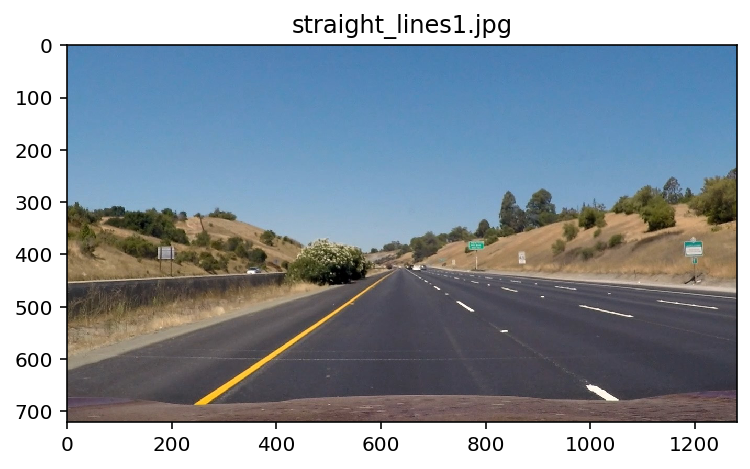

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


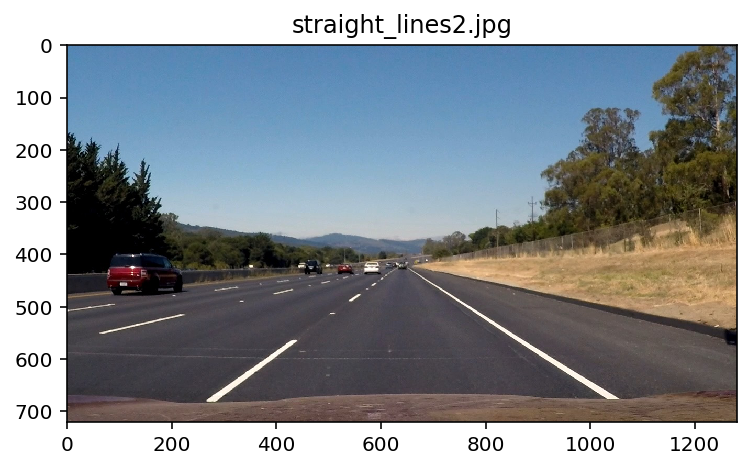

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


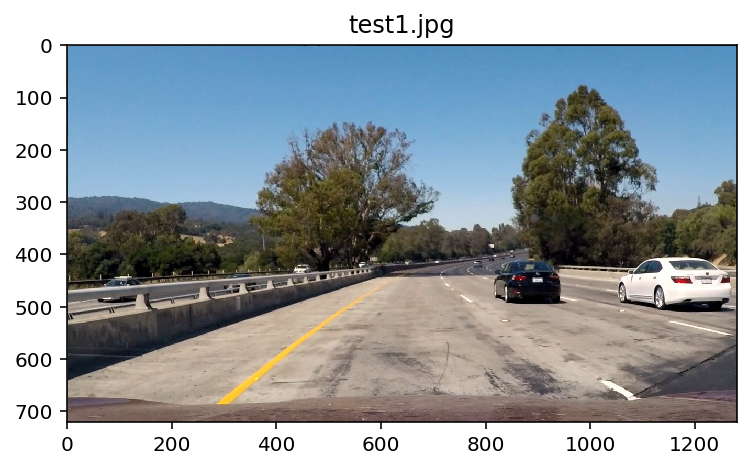

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


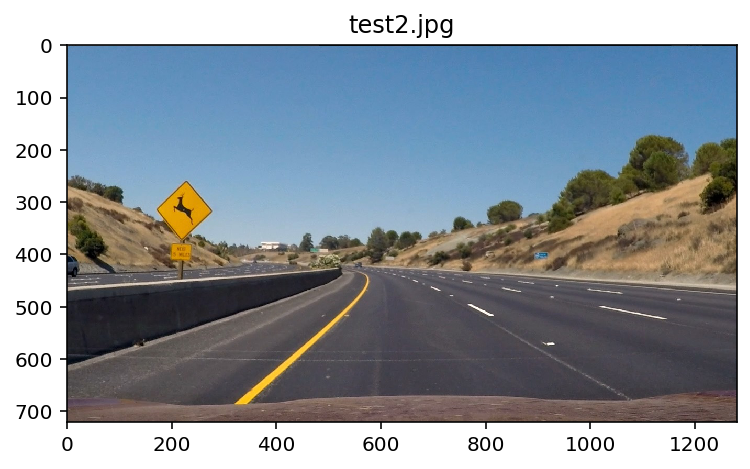

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


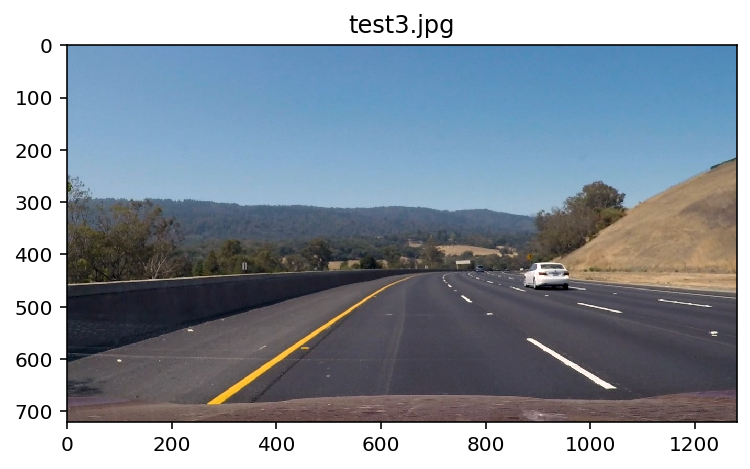

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


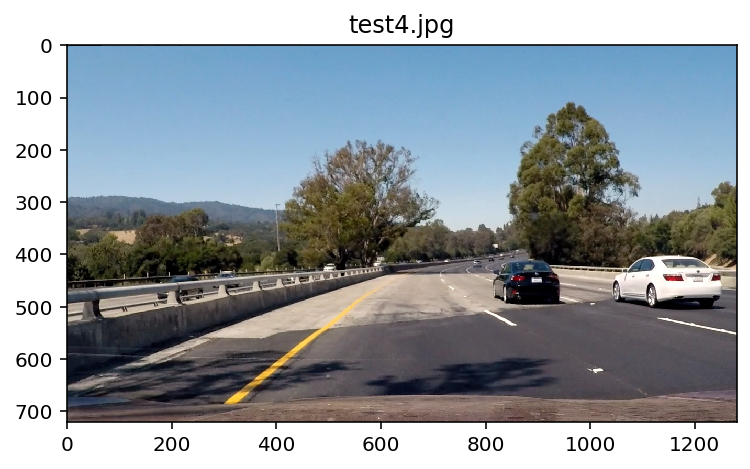

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


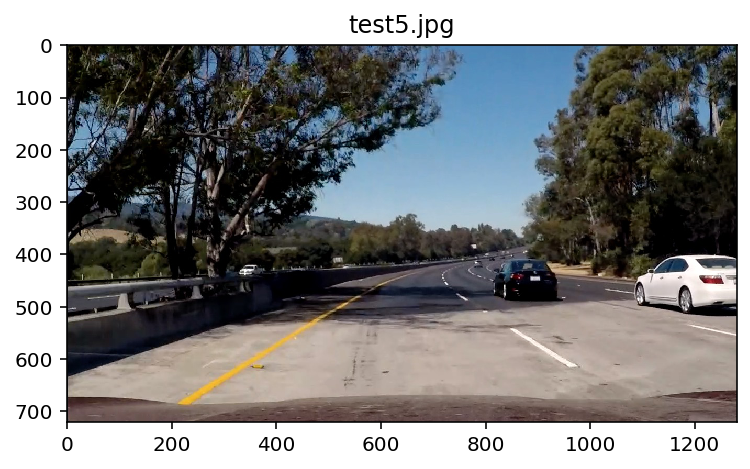

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


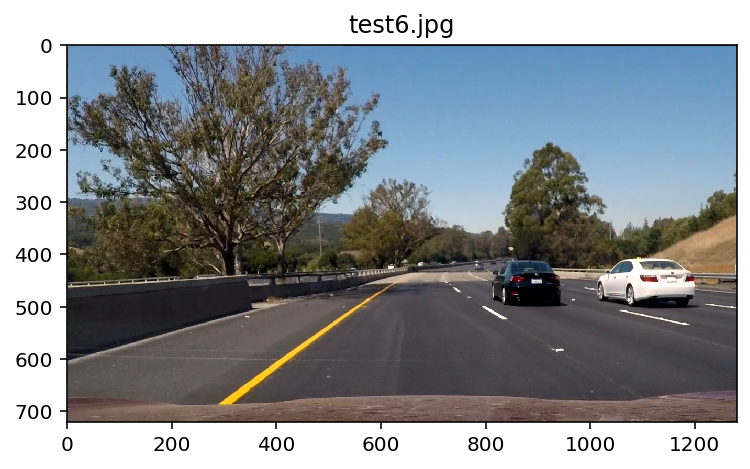

In [3]:
test_files = sorted(os.listdir("test_images/"))
for image_path in test_files:
    image = mpimg.imread('test_images/{}'.format(image_path))
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)
    plt.title(image_path)
    plt.show()

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
1. Apply a distortion correction to raw images.
1. Use color transforms, gradients, etc., to create a thresholded binary image.
1. Apply a perspective transform to rectify binary image ("birds-eye view").
1. Detect lane pixels and fit to find the lane boundary.
1. Determine the curvature of the lane and vehicle position with respect to center.
1. Warp the detected lane boundaries back onto the original image.
1. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [4]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

def perspective_transform(undist, nx, ny, mtx, dist):
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 150 pixels is not exact, but close enough for our purpose here

        offset = 150 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    else:
        warped, M = None, None
    # Return the resulting image and matrix
    return warped, M

In [5]:
dir_name = "camera_cal/"
cal_files = sorted(os.listdir(dir_name))
corner_size = (9,6)
nx, ny = corner_size
fail_list = []

# Object points and image points
objpoints = []
imgpoints = []

it = 1 # the number of iterations
while len(cal_files) > 0:

    for k, image_path in enumerate(cal_files):
        # Load Image
        image = cv2.imread(os.path.join(dir_name, image_path))

        # Convert to Gray image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        objp = np.zeros((np.product(corner_size), 3), np.float32)
        objp[:, :2] = np.mgrid[0:corner_size[0], 0:corner_size[1]].T.reshape(-1, 2)

        # Find Corner
        ret, corners = cv2.findChessboardCorners(gray, corner_size, None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            undist, mtx, dist = cal_undistort(image, objpoints, imgpoints)
            print("{}, {}, {}".format(it, k, mtx.flatten()[:4]), end="\r")
            top_down, perspective_M = perspective_transform(undist, nx, ny, mtx, dist)
            if top_down is not None:
                # remove success calibration file
                cal_files.pop(k)

    it +=1
    
    if(it > 5):
        break

In [6]:
cal_files

['calibration1.jpg',
 'calibration2.jpg',
 'calibration4.jpg',
 'calibration5.jpg']

In [7]:
mtx, dist

(array([[1.16059931e+03, 0.00000000e+00, 6.70125096e+02],
        [0.00000000e+00, 1.15536503e+03, 3.76025179e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-2.71024487e-01,  1.82173956e-01, -1.35957396e-03,
          1.78742291e-04, -3.97025309e-01]]))

In [8]:
def abs_sobel_thresh(img, orient='x',  sobel_kernel=3, thresh=(0, 255)):
    thresh_min, thresh_max = thresh
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output